# **Decision Tree Algorithm**

# **Obare Okebiro Daniel**

**Classifier to predict species in the Iris dataset**

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 50)
import numpy as np
import datetime
from IPython.display import display 
#
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)
import seaborn as sns
sns.set_style('dark')
#
import warnings
warnings.filterwarnings('ignore')
import gc  

In [13]:
#Setting styles and aesthetics
pd.set_option('display.max_columns', 200)
pd.options.display.max_rows =30
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Iris.csv')
#copies
data_copy = data.copy()
#
# Check The Shape Of The Data Loaded
print('Data shape: {} Rows, {} Columns'.format(*data.shape))
#
# Print First Few Rows Of The Data
display("Data display")
display(data.head(3))
display(data.tail(3))

Data shape: 150 Rows, 6 Columns


'Data display'

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica
149,150,5.9,3.0,5.1,1.8,Iris-virginica


In [6]:
data['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

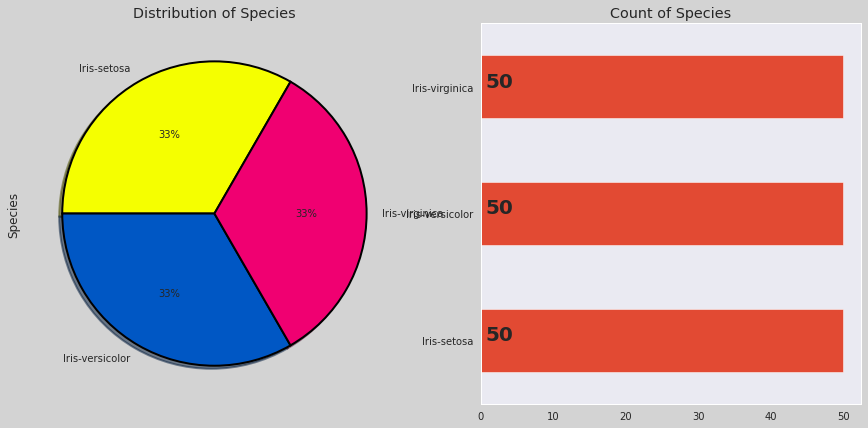

In [7]:
# Distribution of the target variable
fig = plt.figure(figsize=(15, 7))
plt.subplot(121)
data['Species'].value_counts().plot.pie(autopct = "%1.0f%%",  colors = sns.color_palette("prism",7),
                                                                                    startangle = 60,
                                                                                    labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
                                                                                    wedgeprops={"linewidth":2,"edgecolor":"k"},
                                                                                    shadow =True)
plt.title("Distribution of Species")

plt.subplot(122)
ax = data['Species'].value_counts().plot(kind="barh")

for i,j in enumerate(data['Species'].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

plt.title("Count of Species")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")
plt.show()

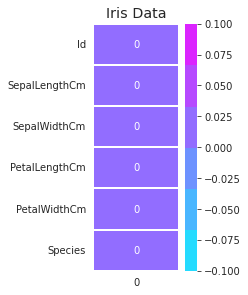

In [8]:
plt.figure(figsize=(12,10))

plt.subplot(231)
sns.heatmap(pd.DataFrame(data.isnull().sum()/data.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("Iris Data")

plt.subplots_adjust(wspace = 1.6)

**Feature Engineering**

In [10]:
#renaming columns
data.columns = data.columns.str.strip().str.lower().str.replace(' ','_')
#
#drop duplicated values in the whole data set
data.drop_duplicates(subset=data.columns, keep='last', inplace=True)
data.columns

Index(['id', 'sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm',
       'species'],
      dtype='object')

In [11]:
#define a function for treating outliers
def treat_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    print('First quantile: ', Q1)
    print('Third quantile: ', Q3)
    print('IQR: ', IQR)
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    print('Lower bound: ', lower_bound, 'Upper bound: ', upper_bound)

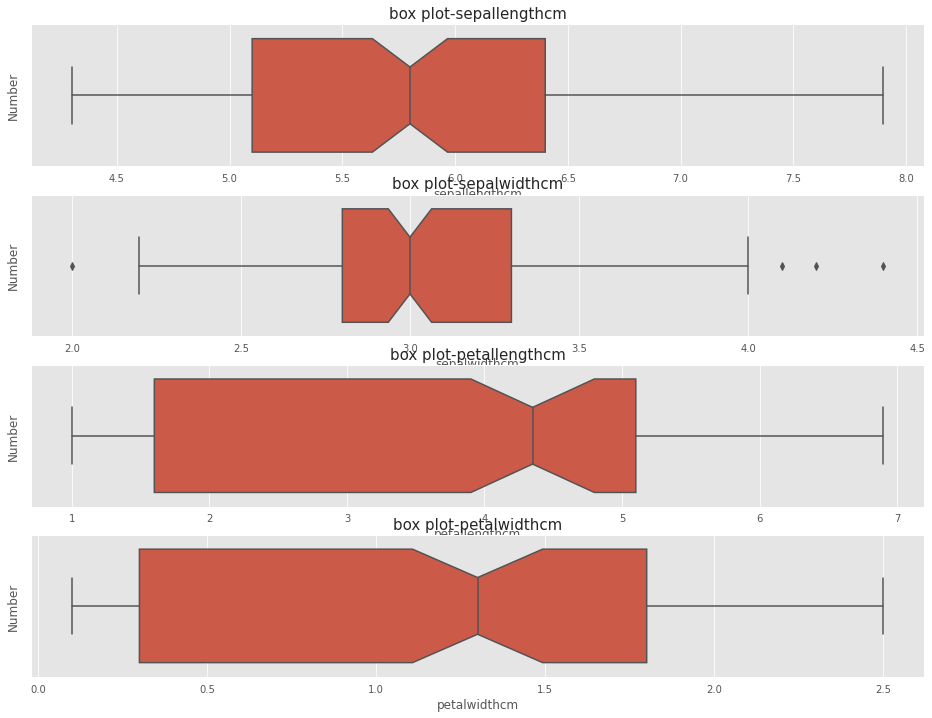

In [14]:
#checking for outliers using box plot
col_names = ['sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm']
fig, ax=plt.subplots(len(col_names), figsize=(16,12))
for i, col_val in enumerate(col_names):
    sns.boxplot(data[col_val], notch= True, ax=ax[i])
    ax[i].set_title ('box plot-'+ col_val, fontsize= 15)
    ax[i].set_xlabel(col_val, fontsize= 12)
    ax[i].set_ylabel('Number', fontsize= 12)

plt.show() 

In [15]:
# rectify outliers
treat_outlier(data, 'sepalwidthcm')

First quantile:  2.8
Third quantile:  3.3
IQR:  0.5
Lower bound:  2.05 Upper bound:  4.05


In [16]:
data = data[(data['sepalwidthcm'] > 2.05) & (data['sepalwidthcm'] < 4.05)]

In [18]:
#rename species as well as map the values to be one hot encoded
data.rename(columns={'species': 'target'}, inplace=True)
data['target'] = data['target'].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
#
column = ['id']
data.drop(column, inplace=True, axis=1)
display(data.head(3))

,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm,target
0,5.10,3.50,1.40,0.20,0
1,4.90,3.00,1.40,0.20,0
2,4.70,3.20,1.30,0.20,0


**Model Selection and Variable importance**

In [19]:
# modelling 
import lightgbm as lgb
#
# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
#
y = data[['target']].astype(int)
#label encode to convet to a multiclass variable
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)
#
X = data.drop(['target'], axis=1)
display(X.head(2))
#
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
0,5.10,3.50,1.40,0.20
1,4.90,3.00,1.40,0.20


In [20]:
# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='multiclass', 
                           boosting_type = 'goss', 
                           n_estimators = 10000, 
                           class_weight = 'balanced')

In [21]:
train_columns = ['sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm']
#
# Split into training and validation set
train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.3, random_state = 27)
# Train using early stopping
model.fit(train_features, train_y, 
          eval_metric = 'logloss', 
          verbose = 200)

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='multiclass')

Feature Importance

In [22]:
#define a function to create variable importance dataframe
def get_lgbm_varimp(model, train_columns, max_vars=50):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp']

    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df

In [23]:
get_lgbm_varimp(model, train_columns)

,feature_name,varimp
3,petalwidthcm,57.75
0,sepallengthcm,18.31
2,petallengthcm,15.49
1,sepalwidthcm,8.45


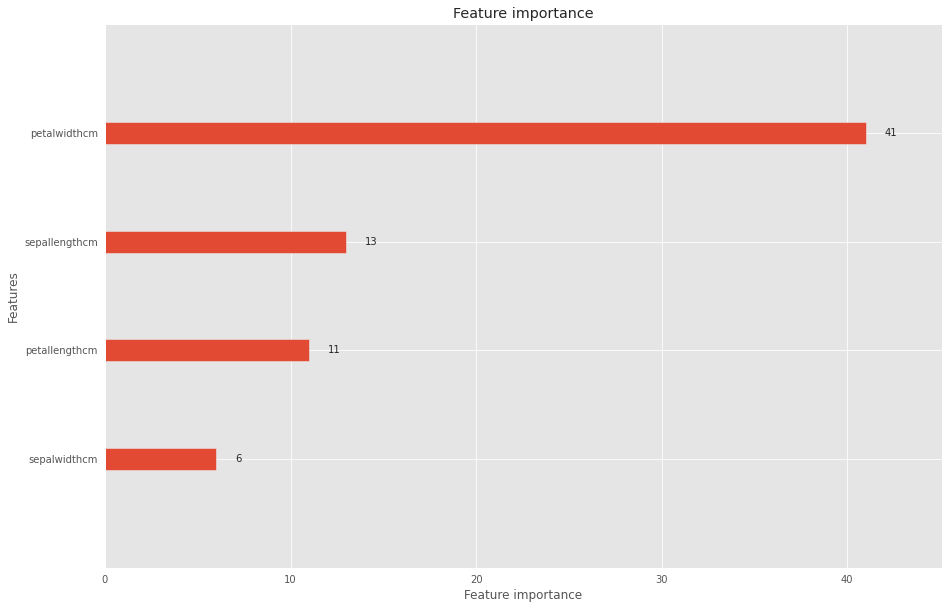

In [24]:
#plot the variable importance
ax=lgb.plot_importance(model, max_num_features=40, figsize=(15,10))
plt.show()

Check Imbalance in the target variable/column

Class=0, n=47 (32.192%)
Class=1, n=49 (33.562%)
Class=2, n=50 (34.247%)


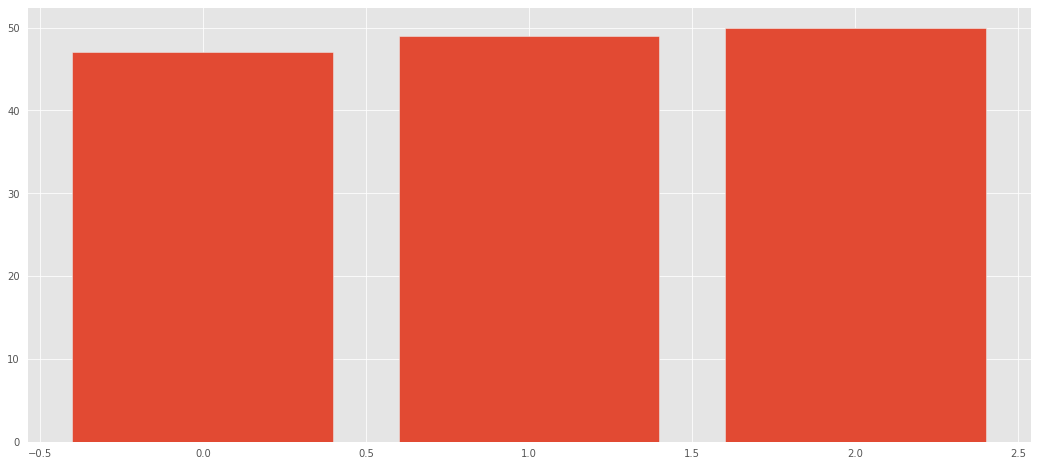

In [25]:
from collections import Counter
import matplotlib.pyplot as plt
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
#
#plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Model Selection

Identify the best model with higher accuracy from a list of classifier models

Calculate the baseline.

In [27]:
#split model
import random
random.seed(1234)
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
#
#model the training set and calculate the metrics
clf = lgb.LGBMClassifier().fit(x_train, y_train)
#
from sklearn.metrics import log_loss, accuracy_score
print('Log Loss: ', log_loss(y_valid, clf.predict_proba(x_valid)))
print('Accuracy: ', accuracy_score(y_valid, clf.predict(x_valid)))

Log Loss:  0.1156697798613052
Accuracy:  0.9318181818181818


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier #Neural networks
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, accuracy_score
#
models = [
    RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0),
    SVC(decision_function_shape="ovo"),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'),
    AdaBoostClassifier(),
    CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, logging_level='Silent',
                        eval_metric='Accuracy', random_state=42),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(objective='multi:softprob', eval_metric='logloss', learning_rate=0.1, max_depth=4, seed=27,
                  n_estimators=20),
    lgb.LGBMClassifier(objective='multiclass', 
                           boosting_type = 'goss', 
                           n_estimators = 1000, 
                           class_weight = 'balanced'),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1),
    DecisionTreeClassifier(max_depth = 2)
]
#
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
print(cv_df.groupby('model_name').accuracy.mean().sort_values())

model_name
LGBMClassifier               0.94
AdaBoostClassifier           0.95
DecisionTreeClassifier       0.95
XGBClassifier                0.95
RandomForestClassifier       0.95
GradientBoostingClassifier   0.96
CatBoostClassifier           0.97
SVC                          0.97
MLPClassifier                0.97
KNeighborsClassifier         0.97
LogisticRegression           0.97
Name: accuracy, dtype: float64


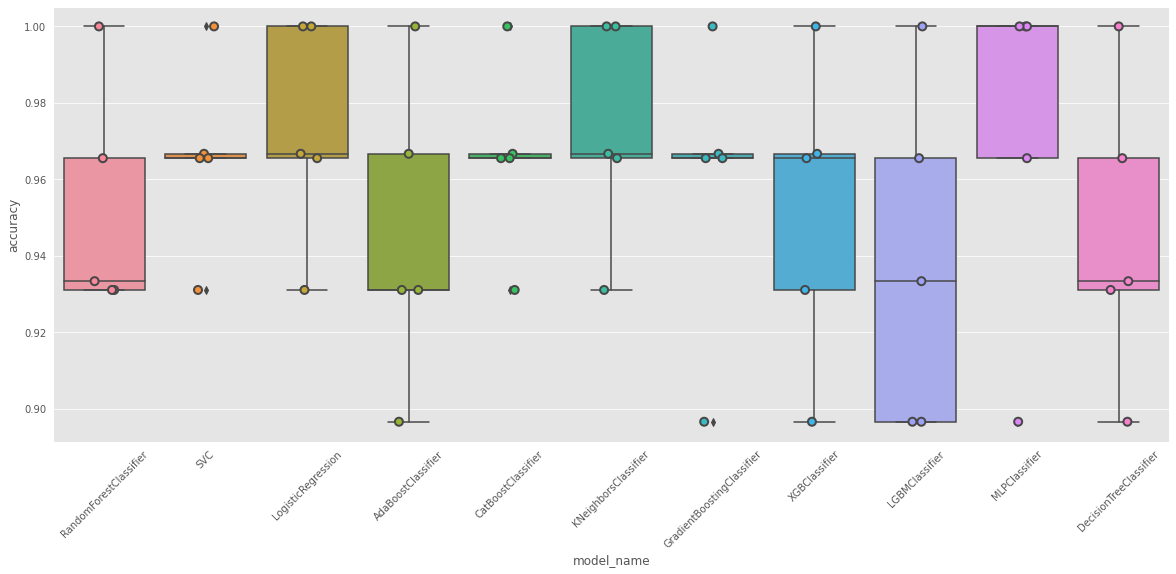

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(20,8)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Logistic Regression

In [33]:
model = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='lbfgs').fit(x_train, y_train)
preds = model.predict(x_valid)
#
print('Log Loss: ', log_loss(y_valid, model.predict_proba(x_valid)))
print("Accuracy:", accuracy_score(y_valid, preds))
#
from sklearn.metrics import mean_squared_error, classification_report
mse=mean_squared_error(y_valid, preds)
print('RandomForest-RMSE: ', np.sqrt(mse))
#
#classification Report
print(classification_report(y_valid, preds))

Log Loss:  0.054999265584005815
Accuracy: 1.0
RandomForest-RMSE:  0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        16

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=1500, class_weight='balanced')
rf.fit(x_train, y_train)
#
rf_pred=rf.predict(x_valid)
#
print('Log Loss: ', log_loss(y_valid, rf.predict_proba(x_valid)))
print("Accuracy:", accuracy_score(y_valid, rf_pred))
#
from sklearn.metrics import mean_squared_error, classification_report
mse=mean_squared_error(y_valid, rf_pred)
print('RandomForest-RMSE: ', np.sqrt(mse))
#
#classification Report
print(classification_report(y_valid, rf_pred))

Log Loss:  0.09715563114708266
Accuracy: 0.9545454545454546
RandomForest-RMSE:  0.21320071635561044
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.91      0.91      0.91        11
           2       0.94      0.94      0.94        16

    accuracy                           0.95        44
   macro avg       0.95      0.95      0.95        44
weighted avg       0.95      0.95      0.95        44



In [43]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_valid)
#
print('Log Loss: ', log_loss(y_valid, clf.predict_proba(x_valid)))
print("Accuracy:", accuracy_score(y_valid, y_pred))
#
from sklearn.metrics import mean_squared_error, classification_report
mse=mean_squared_error(y_valid, y_pred)
print('Decision Tree-RMSE: ', np.sqrt(mse))
#
#classification Report
print(classification_report(y_valid, y_pred))

Log Loss:  0.8737055687604262
Accuracy: 0.9545454545454546
Decision Tree-RMSE:  0.21320071635561044
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.91      0.91      0.91        11
           2       0.94      0.94      0.94        16

    accuracy                           0.95        44
   macro avg       0.95      0.95      0.95        44
weighted avg       0.95      0.95      0.95        44



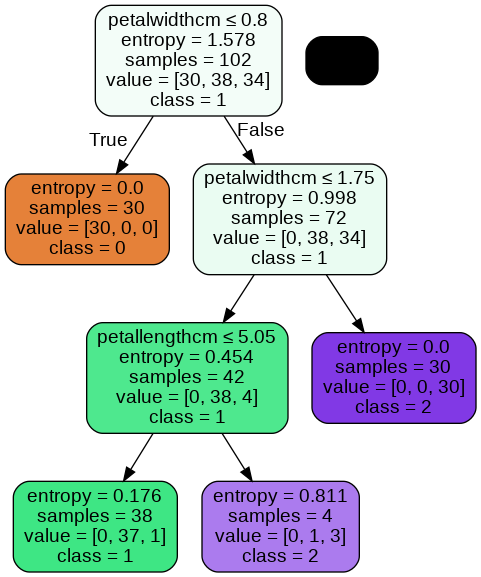

In [44]:
from sklearn.tree import export_graphviz
from six import StringIO
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = train_columns,class_names=['0','1', '2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())